In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
import torch.optim as optim
from PIL import Image, ImageEnhance
import cv2

## Common Funcs

In [2]:
## Loading images
def load_rgb(path):
    img = cv2.imread(path)
    img = img[..., ::-1]
    return img

def load_gray(path):
    img = cv2.imread(path, 0)
    
    return img

In [3]:
def rescale(img):
    e = 1e-4
    return (img - np.min(img)) / (np.max(img) - np.min(img) + e)

In [4]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    img = rescale(img)
    plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:
        plt.imsave(f'../data/outs/{title}.png', img)
        
    plt.show()
    plt.close(fig)


def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    img = rescale(img)
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../imgs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

In [5]:
def hist_eq(img_out) :
    img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
    img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
    img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])
    return img_out

## Occlusion

In [6]:
class CenterCrop224(object):
    
    def __init__(self, output_size=224):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image):
        img = np.array(image)
        h, w = img.shape[:2]
        sz = self.output_size
        
        if h == w: 
            return cv2.resize(img, (sz, sz), cv2.INTER_AREA)
        
        elif h > w:
            scaling_factor = sz / w
            x_shape = sz
            y_shape = int(h * scaling_factor)
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((y_shape - sz) / 2)
            img_reshaped = img_reshaped[offset:offset + sz, :, :]
            
        else :
            scaling_factor = sz / h
            x_shape = int(w * scaling_factor) 
            y_shape = sz
            img_reshaped = cv2.resize(img, (x_shape, y_shape), cv2.INTER_AREA)
            offset = int((x_shape - sz) / 2)
            img_reshaped = img_reshaped[:, offset:offset+sz, :]
        return img_reshaped
cc224 = CenterCrop224()

In [7]:
transform = transforms.Compose([CenterCrop224(), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

# transform = transforms.Compose([VGG16_Weights.IMAGENET1K_V1.transforms])
# transform = VGG16_Weights.IMAGENET1K_V1.transforms

In [8]:
img = cv2.cvtColor(cv2.imread('puffer.JPEG'), cv2.COLOR_BGR2RGB)

img = transform(img)
# img = Image.open('puffer.JPEG')
# print(img.size)

# img = img.transform([244], transforms.InterpolationMode.BILINEAR)

In [9]:
image = transforms.ToPILImage()(img).convert("RGB")

In [10]:
# import json
# f_labels = open('imagenet_class_index.json', 'r')
# labels = json.load(f_labels)
# f_labels.close()

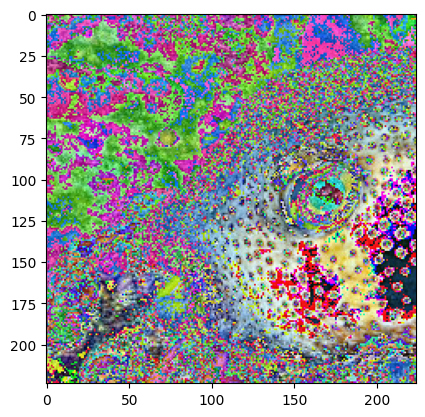

In [11]:
plt.imshow(image)

### Conv Network

In [12]:
class ConvVgg16(nn.Module):
    def __init__(self, save_switches=False):
        super().__init__()
        
        self.save_switches = save_switches
        # indices of Conv2d layres
        self.modules_no = []
        
        pre_model = vgg16(weights='DEFAULT')
        
        # self.features = vgg16(pretrained=True).features
        self.features = pre_model.features
        
        for i, feature in enumerate(self.features) :
            if isinstance(feature, nn.MaxPool2d):
                self.features[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices = True)
            
            elif isinstance(feature, nn.Conv2d):
                self.modules_no.append(i)
            
        # self.avgpool = vgg16(pretrained=True).avgpool
        self.avgpool = pre_model.avgpool
        
        # self.classifier = vgg16(pretrained=True).classifier
        self.classifier = pre_model.classifier
                        
        
    def forward (self, x) :
        conv_results = {}
        maxpool_indices = {}
        for i, layer in enumerate(self.features):
            
            if isinstance(layer, nn.MaxPool2d):
                x, index = layer(x)
                maxpool_indices[i] = index
                
            else :
                x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                conv_results[i] = x
            
        
            
        x = self.avgpool(x)
        x = x.flatten()
        x = self.classifier(x)
        
        
        if not self.save_switches :
            return x    
            
        return x, conv_results, maxpool_indices
    

### Deconv

In [13]:
class ConvDeconvVGG16(nn.Module) :
    def __init__(self) :
        
        super().__init__()
        
        
        self.conv_model = ConvVgg16(save_switches=True)

        
        self.conv_indices = []
        self.maxpool_indices = []
        
        module_list = []
        
        for i, layer in enumerate(self.conv_model.features) :
            if isinstance(layer, nn.Conv2d):
                module_list.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, stride=layer.stride, padding=layer.padding))
                module_list[i].weight.data = layer.weight.data
                self.conv_indices.append(i)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_list.append(nn.MaxUnpool2d(kernel_size=2, stride=2))
                self.maxpool_indices.append(i)
                
            elif isinstance(layer, nn.ReLU):
                module_list.append(nn.ReLU(inplace=True))
        
        module_list.reverse()
        self.module_list = nn.ModuleList(module_list)
     
    
    def __zero_activation(self, y, k) :
        if k == 'channel' :
            y_sum = y.sum(axis=1).sum(axis=1)
            y_argmax = y_sum.argmax().item()
            y_zerod = torch.zeros_like(y)
            y_zerod[y_argmax, :, :] = y[y_argmax, :, :]
            return y_zerod
        
        elif k == 'pixel' :
            y_idx = y.argmax().item()
            y_max = y.max().item()
            y_zerod = torch.zeros_like(y).flatten()
            y_zerod[y_idx] = y_max
            return y_zerod.reshape(y.shape)
    
        
    def forward(self, x, layer_ix, zero_type='channel') :
        
        conv_pred_vector, conv_results, switches  = self.conv_model(x)
        conv_pred = conv_pred_vector.argmax().item()
        
        y = conv_results[self.conv_indices[layer_ix]]
        y = self.__zero_activation(y, zero_type)

        
        
        for i, layer in enumerate(self.module_list[(30 - self.conv_indices[layer_ix]):]) :
            if isinstance(layer, nn.MaxUnpool2d):
                y = layer(y, switches[self.conv_indices[layer_ix] - i])
            else :
                y = layer(y)
                
        ret = {"pred_prob" : conv_pred_vector, "pred" : conv_pred, "conv_results": conv_results, "deconv" : y}
        return ret
        
        

In [14]:
model = ConvDeconvVGG16()
print()

In [15]:
out = model(img, 7)
# print(f"Class : {out['pred']}: {labels[str(out['pred'])][1]}")

In [16]:
img_out = out['deconv'].permute(1, 2, 0).detach().cpu().numpy()

In [17]:
img_out = (img_out - img_out.min()) / (img_out.max() - img_out.min())
# img_out = (img_out * 255).astype(np.uint8)

In [18]:
# # Histogram equalization on img_out
# img_out[:, :, 0] = cv2.equalizeHist(img_out[:, :, 0])
# img_out[:, :, 1] = cv2.equalizeHist(img_out[:, :, 1])
# img_out[:, :, 2] = cv2.equalizeHist(img_out[:, :, 2])

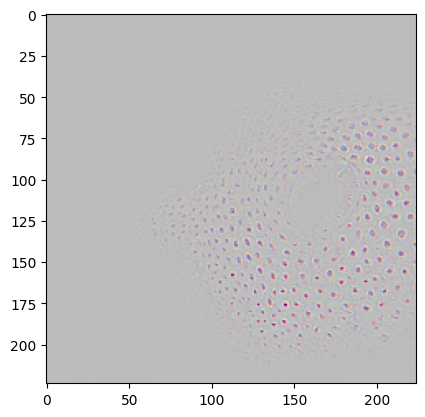

In [19]:
plt.imshow(img_out)

#### Occlusion

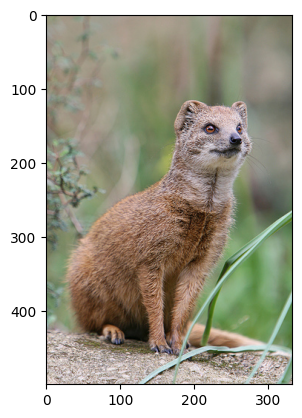

In [20]:
model = ConvDeconvVGG16()

img = cv2.cvtColor(cv2.imread('mong.JPEG'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [21]:
def generate_class_map(img, label, occ_sz, step) :
    
    dim = ((224 - occ_sz) // (step - 1)) + 1
    
    class_map = np.zeros(shape=(dim, dim))
    prob_map = np.zeros(shape=(dim , dim))
    
    for i in range(0, 244 - occ_sz, step) :
        for j in range(0, 244 - occ_sz, step) :
            
            img_cpy = transform(img.copy())
            img_cpy[:, i:i+occ_sz, j:j+occ_sz] = 0.5
            
            res = model(img_cpy, 1, zero_type='pixel')
            
            pred = res['pred']
            oc_label = res['pred_prob'][label].item()
            
            class_map[i // step, j // step] = pred
            prob_map[i // step, j // step] = oc_label
    
    return class_map, prob_map

In [22]:
class_map, prob_map = generate_class_map(img, 298, 55, 10)

In [23]:
img = cv2.cvtColor(cv2.imread('mong.JPEG'), cv2.COLOR_BGR2RGB)
occ_sz = 50
img_cpy = transform(img)
res = model(img_cpy, 9, zero_type='pixel')
img_out_og = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_og = (img_out_og - img_out_og.min()) / (img_out_og.max() - img_out_og.min())
img_out_og = (img_out_og * 255).astype(np.uint8)

In [24]:
img_cpy = transform(img.copy())
img_cpy[:, 20:20 + occ_sz, 130:130 + occ_sz] = 0.5
res = model(img_cpy, 9, zero_type='pixel')
img_out_occ = res['deconv'].permute(1, 2, 0).detach().cpu().numpy()
img_out_occ = (img_out_occ - img_out_occ.min()) / (img_out_occ.max() - img_out_occ.min())
img_out_occ = (img_out_occ * 255).astype(np.uint8)


Text(0.5, 1.0, 'Class Map')

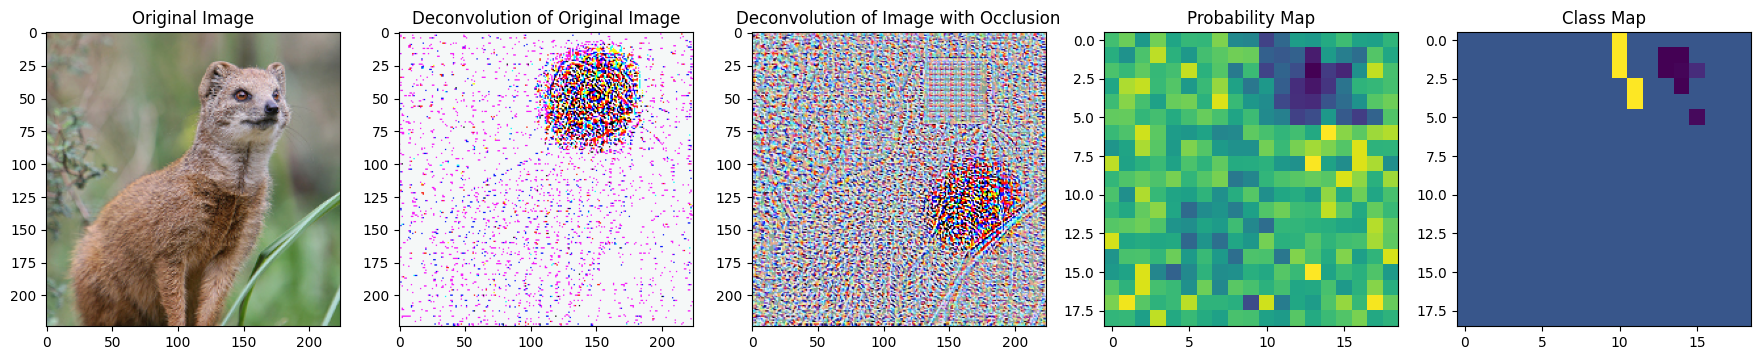

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(22, 18))
fig.set_facecolor('white')

ax[0].imshow(cc224(img))
ax[0].set_title('Original Image')

ax[1].imshow(hist_eq(img_out_og))
ax[1].set_title('Deconvolution of Original Image')

ax[2].imshow(hist_eq(img_out_occ))
ax[2].set_title('Deconvolution of Image with Occlusion')

ax[3].imshow(prob_map)
ax[3].set_title('Probability Map')

ax[4].imshow(class_map)
ax[4].set_title('Class Map')

## Feature Invariance

In [66]:
def ImgCrops(image, n_crops = 5, output_size=224):
    img = np.array(image)
    h, w = img.shape[:2]

    crop_size = 256
    output_size = 224

    print(f'h={h}, w={w}')
    print()
    
    h1 = min(h, crop_size)
    w1 = min(w, crop_size)
    
    if h > w:
        
        img = cv2.resize(img, (w1, h), cv2.INTER_AREA)

        k = int(h // 2 - h1 // 2 + 1)
        img = img[k : k + h1, ...]
        

    else:
        img = cv2.resize(img, (w, h1), cv2.INTER_AREA)

        k = int(w // 2 - w1 // 2 + 1)
        img = img[:, k : k + w1, ...]
    
    h2 = min(h1, output_size)
    w2 = min(w1, output_size)
    
    dh = int(h1 // 2 - h1 // 2 + 1)
    dw = int(h1 // 2 - w2 // 2 + 1)
    
    ddh = int((h1 - h2) // (n_crops - 1))
    
    img_center_crop = img [:, dw : dw + output_size, ...]
    img_crops = [img_center_crop[ddh * i : ddh * i + output_size, ...] for i in range(n_crops)]
    
    img_center = img[int() : int()]
    return img, np.array(img_crops)

In [67]:
img = load_rgb(f'mong.JPEG')
img_crops = ImgCrops(img, n_crops=10)

print(f'img_crops: {img_crops.shape}')

h=500, w=333

img_crops: (10, 224, 224, 3)


In [78]:
def plot_grid(imgs, _figsize=None, _dpi=100):
    n = len(imgs)
    
    w = 5
    h = (n // w + (n % w > 0))
    
    print(f'h={h}, w={w}')
    print()
    
    fig, ax = plt.subplots(h, w, figsize=_figsize, dpi=_dpi)
    
    for i in range(n):
        ax[i // w, i % w].imshow(imgs[i])
        ax[i // w, i % w].set_title(f'Translate: {i + 1}')
     
    for i in range(n, h * w):
        ax[i // w, i % w].axis('off')
        

    # plt.subplots_adjust(wspace=0, hspace=0)
    
    # fig.savefig(name)
    plt.suptitle(f'Verticle Translation')
    plt.show()
    plt.close(fig)

h=2, w=5



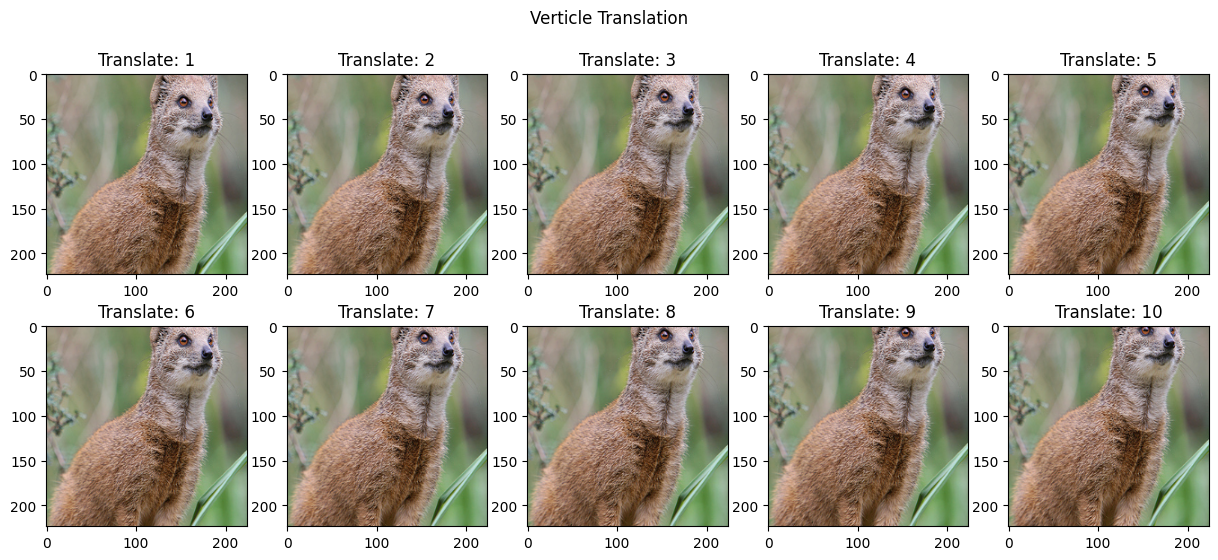

In [77]:
plot_grid(img_crops, _figsize=(15, 6))

In [ ]:
def euclidean_distance(vec1: Tensor, vec2: Tensor):
    # dim=None flattens the vector to find the euclidean distance
    return torch.linalg.vector_norm(vec1 - vec2, ord=2, dim=None)

In [ ]:
def euclidean_distance_test():
    
    vec1 = torch.arange(9, dtype=torch.float32).reshape(3, 3)
    vec2 = torch.zeros_like(vec1, dtype=torch.float32)

    print(euclidean_distance(vec1, vec1) == 0)
    print(euclidean_distance(vec1, vec2) == np.sqrt(np.sum(np.arange(9)**2)))

In [ ]:
transform_2 = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
def feature_distance(img_crops):
    img_features_1 = []
    for i in range(len(img_crops)):
        img = img_crops[i].copy()
        img_trans = transform_2(img_crops)
        
        res = model(img_cpy, 7, zero_type='pixel')